<h1>
	Markov chain diffusion demo on 2D Toy data
</h1>

Based on the work of Niels Rogger and Kashif Rasul

In [ ]:
%matplotlib inline


import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import math

import torch
import torch.nn.functional as F

from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize
from torchvision.utils import save_image


# use seed for reproducability
torch.manual_seed(0)

import numpy as np

### Create Data

torch.Size([60000, 1, 2])


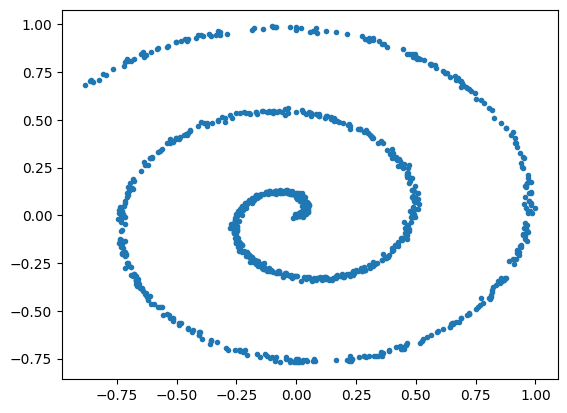

In [ ]:
t=np.linspace(0,15,60000)
noise=0.1*np.random.randn(2,len(t))
y=t*np.sin(t)+noise[0,:]
x=t*np.cos(t)+noise[1,:]
x=x/np.max(x)
y=y/np.max(y)

npdata=np.stack([x,y]).T
np.random.shuffle(npdata)
npdata=np.expand_dims(npdata, [1])

plt.plot(npdata[:1000,0,0],npdata[:1000,0,1],'.')

data=torch.from_numpy(npdata).float()
print(data.shape)

In [ ]:
data[23]

tensor([[0.4874, 0.8369]])

### Create beta schedule

In [ ]:
def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

Let $\alpha_t \doteq 1-\beta_t$, $\bar \alpha_T = \prod_{t=1}^T \alpha_t$

$q(x_T|x_{0})= \mathcal{N}(x_T;\sqrt{\bar\alpha_T}x_{0},(1-\bar\alpha_T)I)$

In [ ]:
timesteps = 200

# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps)

# define alphas 
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
#alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
#sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
#posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)


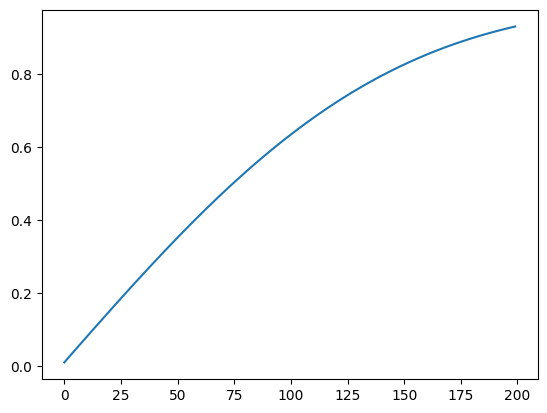

In [ ]:
plt.plot(sqrt_one_minus_alphas_cumprod )

### Diffusion with beta schedule

In [ ]:
# forward diffusion
def q_sample_simple(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)
    
    sqrt_alphas_cumprod_t=sqrt_alphas_cumprod[t]
    sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod[t]
    x_noisy= sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

    return x_noisy

In [ ]:
x_start = data[0,:]
t = torch.tensor([40])

q_sample_simple(x_start, t)

tensor([[ 0.1581, -0.2793]])

Let us visualize the steps

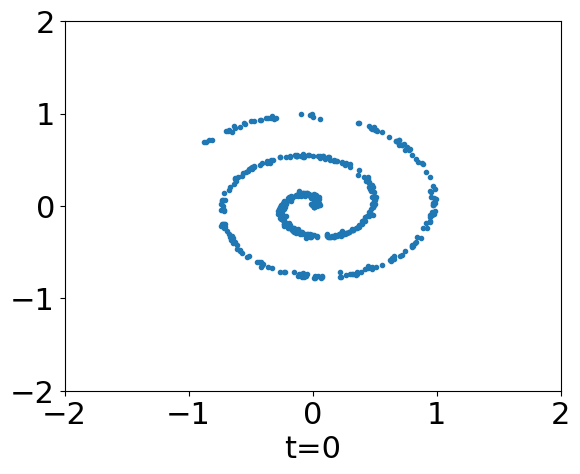

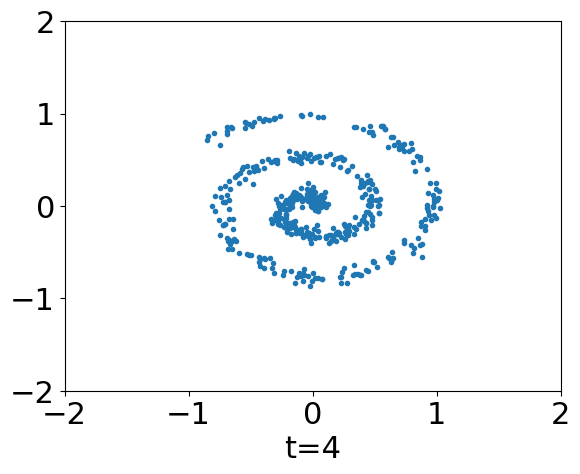

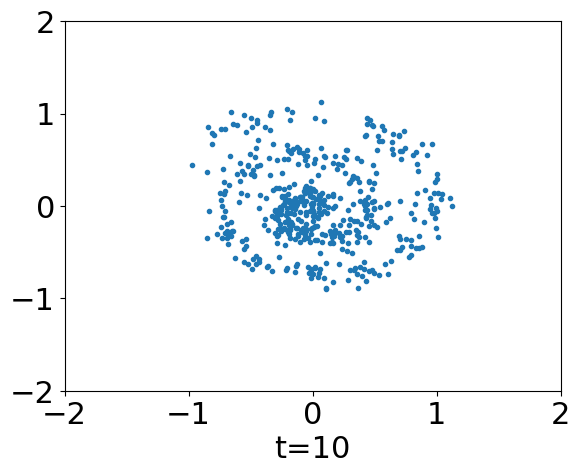

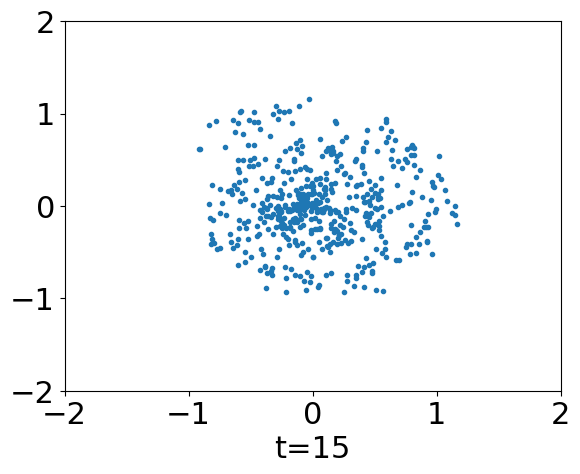

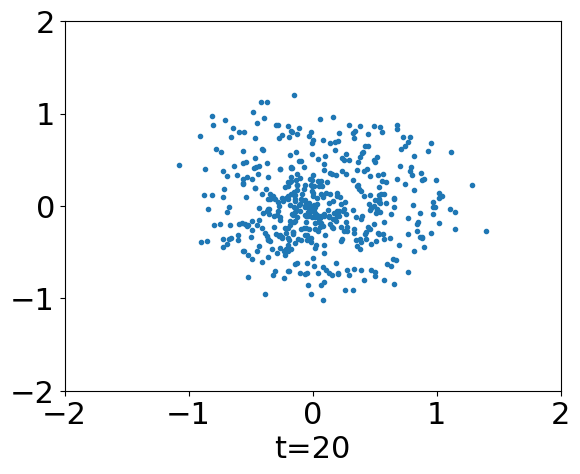

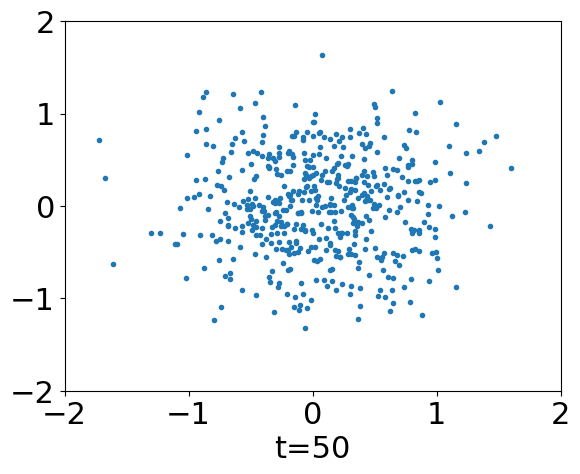

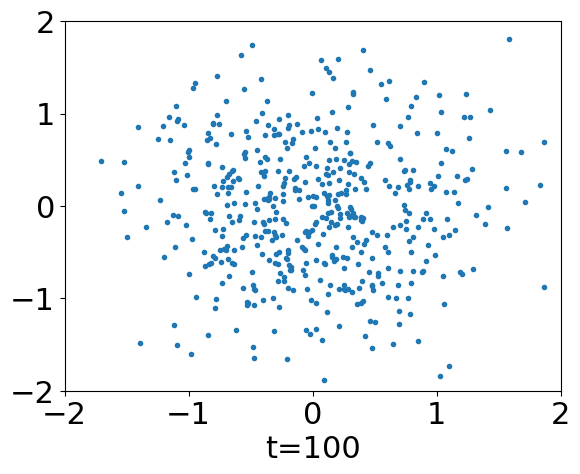

In [ ]:
plt.rcParams.update({'font.size': 22})
for t in [0,4,10,15,20,50,100]:
  bbb=q_sample_simple(data[:,0,:], torch.tensor([t])).numpy()
  ccc=np.stack(bbb)
  fig = plt.figure()
  plt.plot(ccc[:500,0],ccc[:500,1],'.')
  plt.ylim(-2, 2)
  plt.xlim(-2, 2)
  plt.xlabel(f't={t}')